In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#default_exp search

In [3]:
#export
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)
import numpy as np
import pandas as pd

prod


In [4]:
#export
## temp while api is not aperational
# from food.clipmodel import *
from PIL import Image

In [5]:
# #export
# foods = read_sql('foods')
# # foods = foods.drop(columns = ['clip'])
# foods = foods.set_index('id')

In [6]:
#export
q = """select  i.food_id,f.description, f.category,f.energy,f.protein,f.carb,f.fat,i.clip,i.id 
               from food.foods_prompted_images i 
               join food.foods f on (f.id = i.food_id)"""
foods = pd.read_sql(q,engine).set_index('id')

In [7]:
len(foods)

104276

In [8]:
def mean_vector(g):
    return series2tensor(g).mean(0).reshape(768).detach().clone()

In [9]:
#export
def read_image_from_url(url=None,path=None):
    if url: response = requests.get(url, stream=True)
    if path: pass
    return Image.open(response.raw)



In [10]:
#export
def search_image_(url=None,head = 1,env='dev'):
    client = dev_client if env == 'dev' else prod_client
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    image_clip = torch.Tensor(image_clip)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return image_clip,df.reset_index()

series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [11]:
#export
drop_vector =      lambda clip, i: torch.cat([clip[0:i], clip[i+1:]])

def multiply_vector(clip,i,n=1):
    duplicated = torch.cat([clip[i].reshape(1,768) for _ in range(n)])
    return torch.cat([clip, duplicated.reshape(n,768)])

In [12]:
#export
def multiple_foods(url,env='dev'):

    image_clip,selected = search_image_(url,head=100,env=env)
    # selected=selected[selected['category'].isin(selected_categories)]
    selected=selected.reset_index(drop=True)
    clip = series2tensor(selected['clip'])
    initscore = float(cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768)).detach().clone())
    startscore = initscore-0.0000001
    n=0

    while startscore !=initscore:
        startscore = initscore
        
        selected = selected.reset_index(drop=True)
        for i in reversed(selected.index):
            clip = series2tensor(selected['clip'])
            dropped = drop_vector(clip,i)
            testscore = float(cos(image_clip.reshape(1,768), dropped.mean(0).reshape(1,768)).detach().clone())

            if testscore > initscore-0.0001: 
                r = selected.loc[i,'description']
                selected = selected.drop(i)
                initscore = testscore

            else:
                extra = multiply_vector(clip,i,1)
                testscore = float(cos(image_clip.reshape(1,768), extra.mean(0).reshape(1,768)).detach().clone())
                if testscore > initscore: 
                    selected = selected.append(selected.loc[i])
                    initscore = testscore

            n+=1
            if n ==15:break

        print(initscore)
    count = selected.groupby('description')['clip'].count().sort_index()
    r = selected.drop_duplicates('description').set_index("description").sort_index()
    r['count'] = count
    r = r.sort_values('count',ascending = False)
    r['share'] = r['count'].cumsum()/r['count'].sum()

    description = '. '.join(r[r['share']<0.9].index.unique().tolist())


    return r.drop(columns = ['clip']), description, selected,initscore
    

In [13]:
#export
def search_image(url,env='dev'):
    r, desc, sel,score = multiple_foods(url,env=env)
    df = sel[['energy','protein','carb','fat','score']].mean().to_frame().T
    df['score'] =score
    df['description'] = desc
    return df


In [19]:
url = 'https://image.shutterstock.com/z/stock-photo-hummus-with-olive-oil-paprika-lemon-and-pita-bread-1412932103.jpg'

In [20]:
r, desc, sel,score = multiple_foods(url,env='prod')

0.8665975039550284
0.8904341992389804
0.8959810489428258
0.8961135291900622
0.8960813004327988
0.8960220450265307
0.8960432367955516
0.8960432367955516


In [21]:
desc

'Vegetable dip, light. Falafel. Eggplant dip. Greek Salad, no dressing. Onion dip, light. Potato, roasted, NFS. Asparagus, frozen, cooked with butter or margarine. Chicken "wings" with hot sauce, from other sources. Shrimp and vegetables excluding carrots, broccoli, and dark-green leafy; no potatoes, no sauce'

In [22]:
r

,id,food_id,category,energy,protein,carb,fat,score,count,share
description,,,,,,,,,,
"Vegetable dip, light",6988,1097922,"Dips, gravies, other sauces",197.0,2.04,13.60,15.19,0.819301,4,0.190476
Falafel,45293,1100423,"Bean, pea, legume dishes",509.0,8.24,29.01,41.16,0.772651,3,0.333333
Eggplant dip,96989,1103638,"Dips, gravies, other sauces",162.0,4.25,9.63,13.25,0.798465,2,0.428571
"Greek Salad, no dressing",87903,1103407,Vegetable dishes,42.0,2.62,3.84,2.14,0.782423,2,0.523810
"Onion dip, light",6887,1097916,"Dips, gravies, other sauces",165.0,2.00,11.88,12.34,0.798465,2,0.619048
"Potato, roasted, NFS",81380,1102899,"White potatoes, baked or boiled",125.0,1.87,20.45,4.24,0.764513,2,0.714286
"Asparagus, frozen, cooked with butter or margarine",87987,1103428,Other vegetables and combinations,37.0,2.87,1.87,2.58,0.761314,1,0.761905
"Chicken ""wings"" with hot sauce, from other sources",16792,1098565,"Chicken, whole pieces",265.0,17.02,5.08,19.93,0.772464,1,0.809524
"Shrimp and vegetables excluding carrots, broccoli, and dark-green leafy; no potatoes, no sauce",32728,1099724,Seafood mixed dishes,123.0,9.25,6.78,6.87,0.768404,1,0.857143


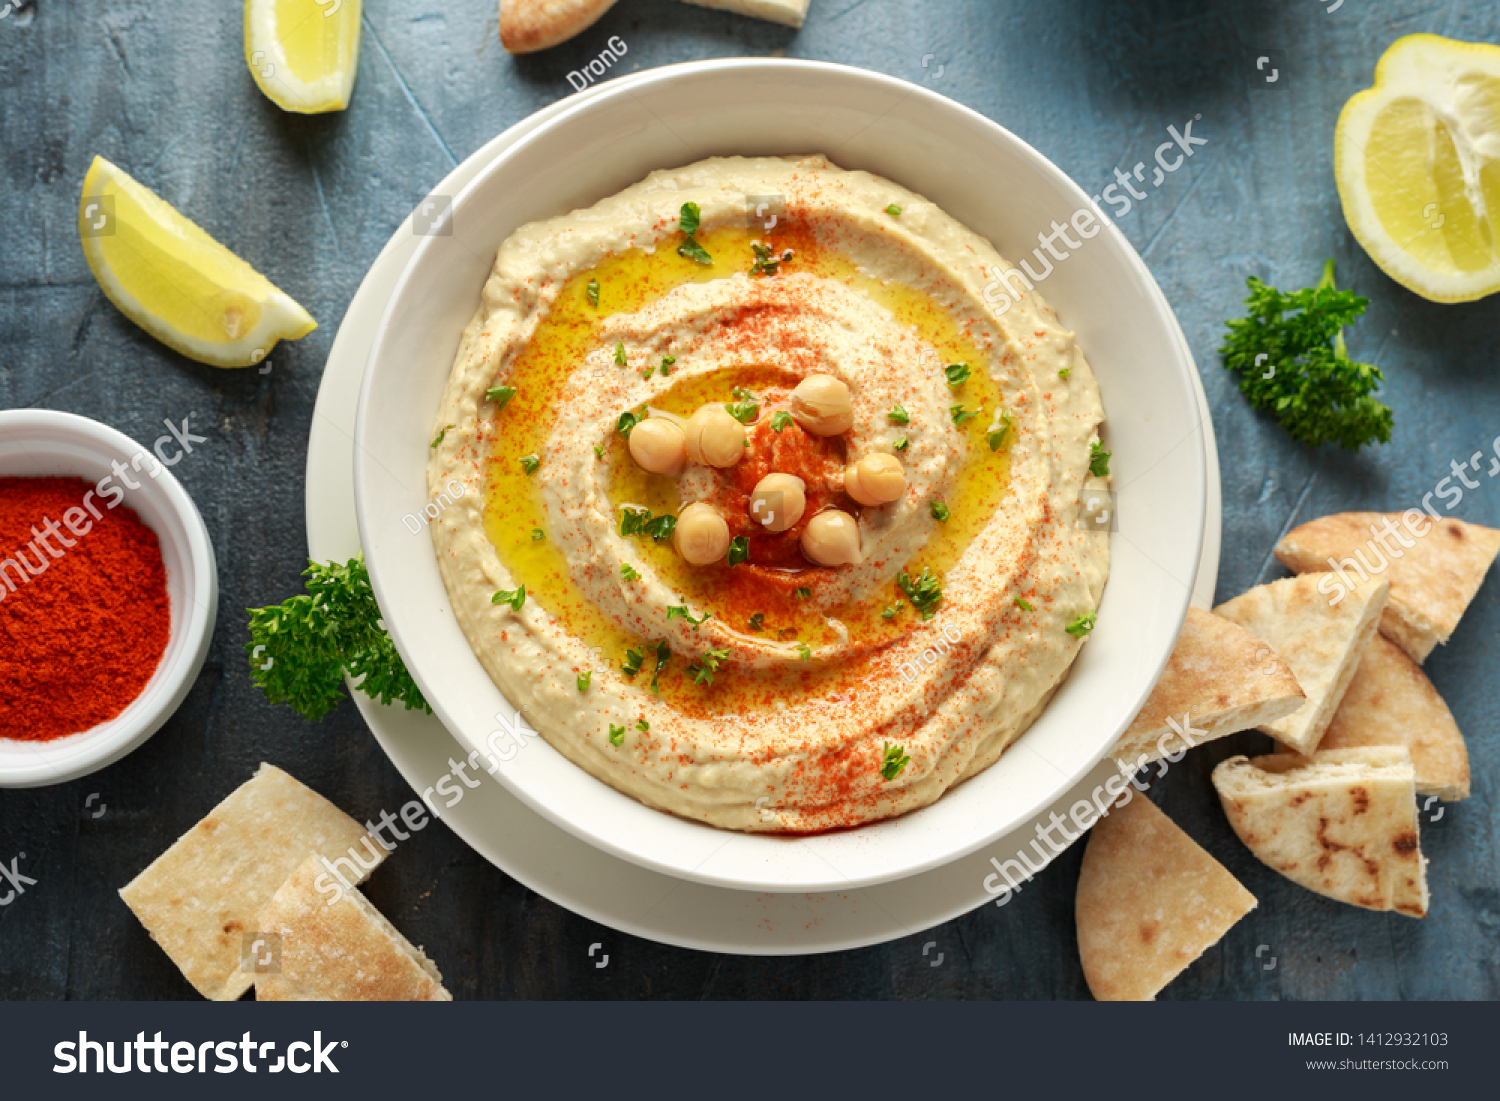

In [23]:
get_image_from_url(url)

In [19]:
search_image(url,'prod')

0.9241994199612956
0.9489574442447687
0.9554999711028429
0.9556667475742928
0.9557574340674231
0.955895068238691
0.955895068238691


,energy,protein,carb,fat,score,description
0,226.45,12.842,15.741,12.168,0.955895,"Egg, cheese and sausage on bagel. Hamburger, f..."


In [20]:
!nbdev_build_lib

Converted 00_clipmodel.ipynb.
Converted 00_custom_pandas.ipynb.
Converted 00_paths.ipynb.
Converted 00_progress_check.ipynb.
Converted 00_psql.ipynb.
Converted 00_qdrant.ipynb.
Converted 00_tools.ipynb.
Converted 01_search.ipynb.
Converted inference.ipynb.
Converted stats.ipynb.
